In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:

df = pd.read_csv('../input/delhids/Dataset.csv')
print(type(df)) 

df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.set_index('Date', inplace=True)
df = df.sort_index()  


<class 'pandas.core.frame.DataFrame'>


In [3]:
def create_features(df):
    df = df.copy()
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

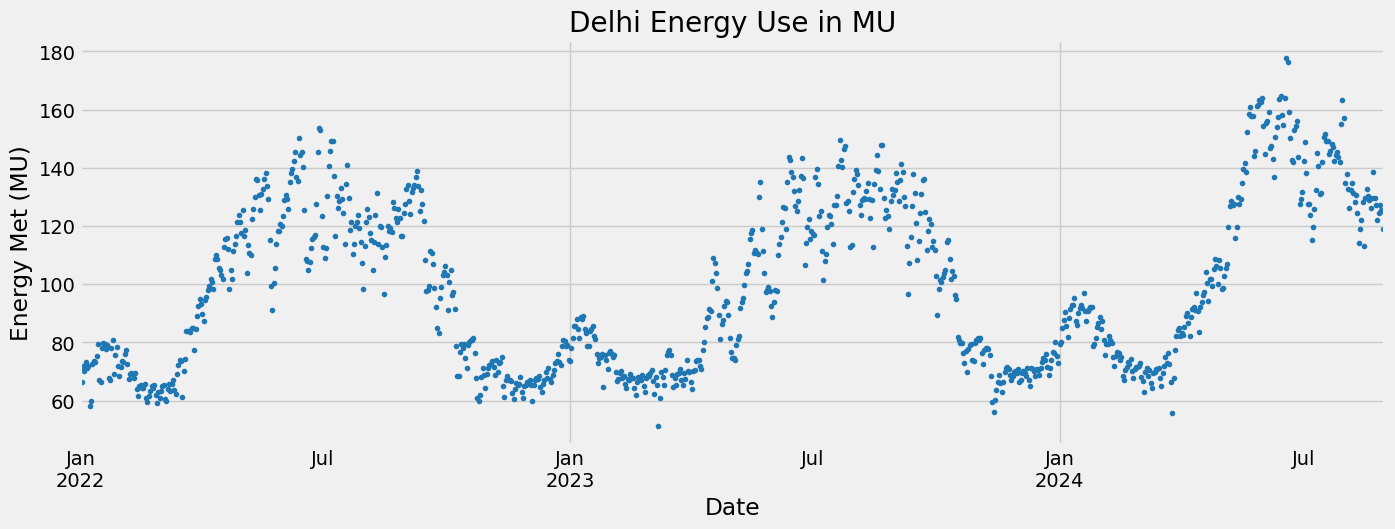

In [4]:
df['Energy Met (MU)'].plot(style='.',
                      figsize=(15,5),
                      color=color_pal[0],
                      title='Delhi Energy Use in MU')
plt.xlabel('Date')
plt.ylabel('Energy Met (MU)')
plt.show()

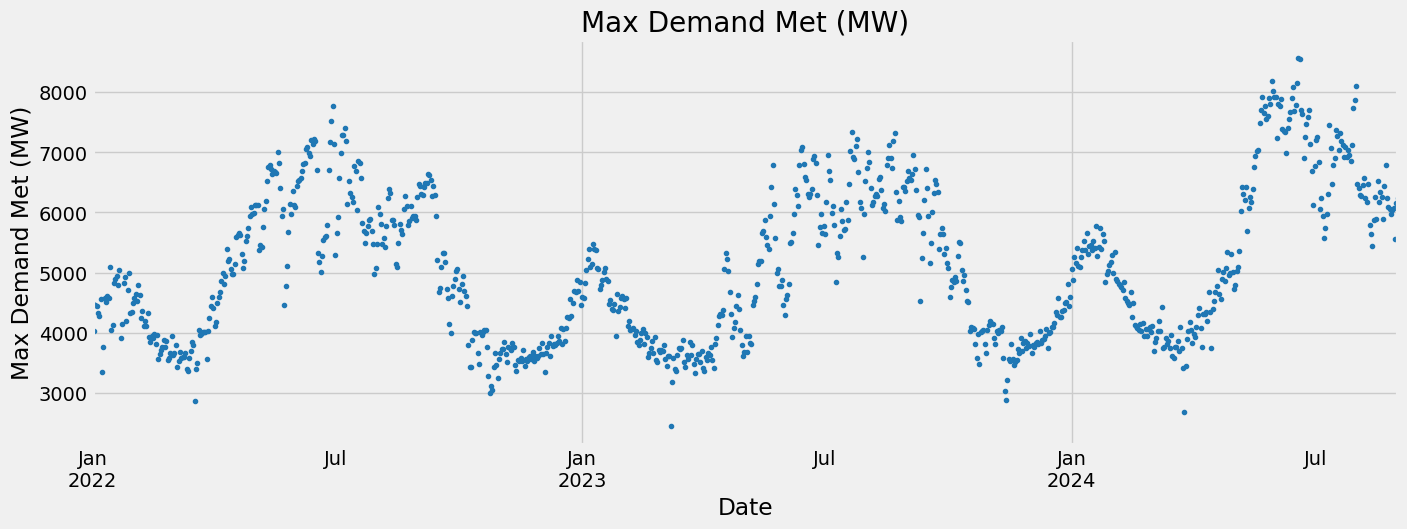

In [5]:
df['Max Demand Met (MW)'].plot(style='.',
                      figsize=(15,5),
                      color=color_pal[0],
                      title='Max Demand Met (MW)')
plt.xlabel('Date')
plt.ylabel('Max Demand Met (MW)')
plt.show()

<Axes: xlabel='Date'>

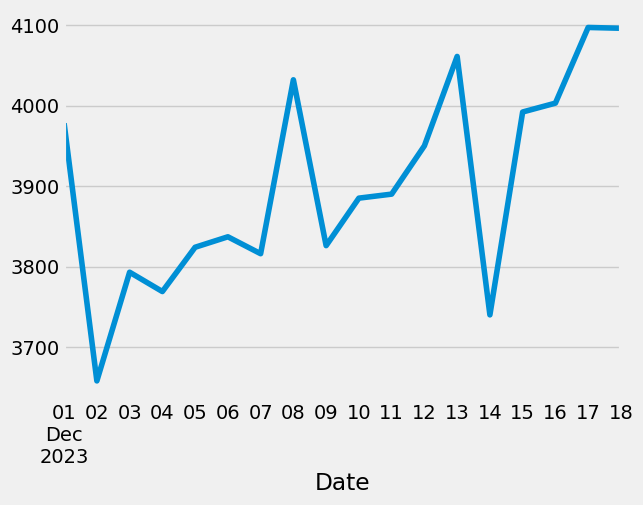

In [6]:
df['Max Demand Met (MW)'].loc[(df.index >= '12-01-2023')  & (df.index <= '12-18-2023')].plot()

<Axes: xlabel='Date'>

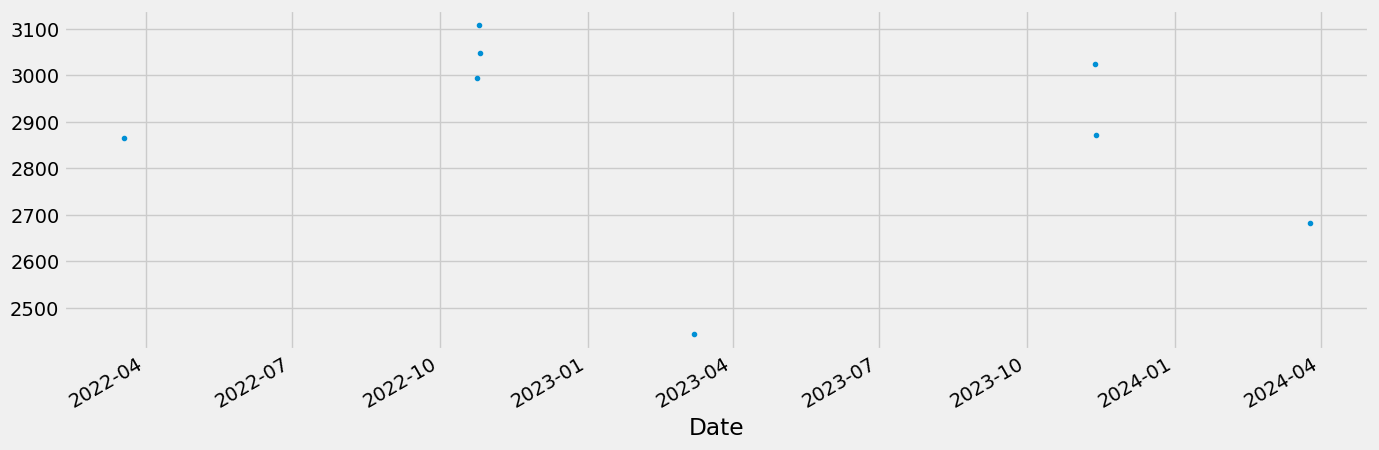

In [7]:
df.query('`Max Demand Met (MW)` < 3150')['Max Demand Met (MW)'].plot(figsize=(15,5), style='.')


In [8]:
df = df.query('`Max Demand Met (MW)` > 3150').copy()

# Train/Test Split

In [9]:
tss = TimeSeriesSplit(n_splits=5)
df = df.sort_index()

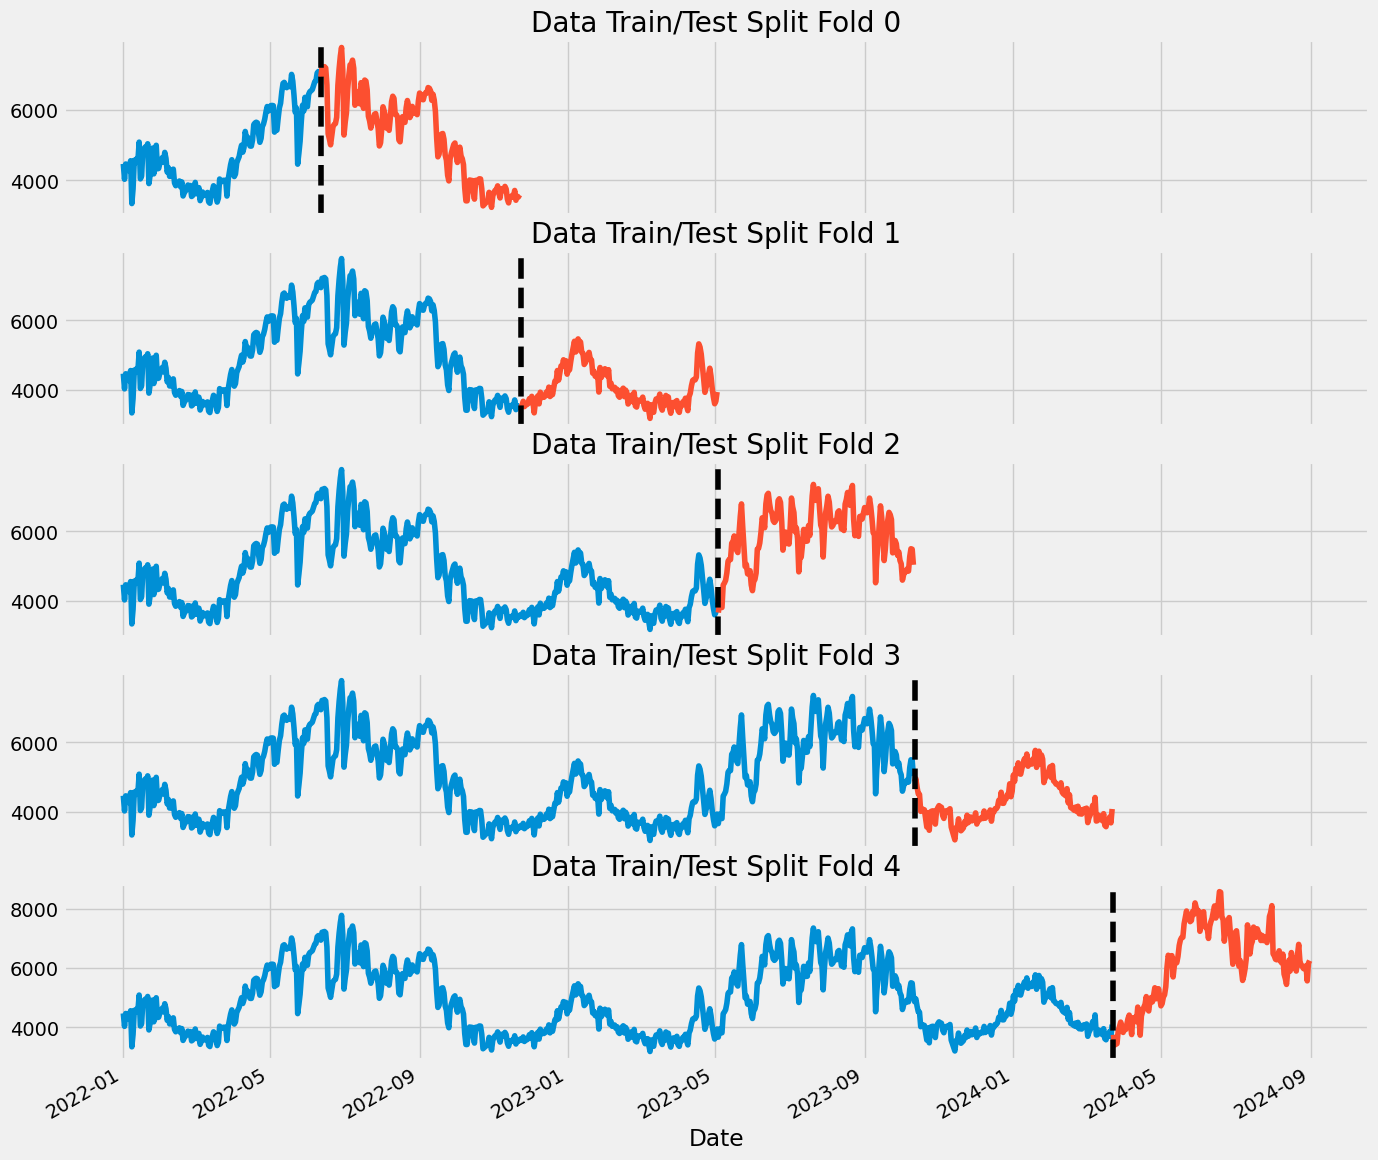

In [10]:

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train['Max Demand Met (MW)'].plot(ax=axs[fold],
                                     label='Training Set',
                                     title=f'Data Train/Test Split Fold {fold}')

    test['Max Demand Met (MW)'].plot(ax=axs[fold],
                                    label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')

    fold += 1

plt.show()


In [11]:
def add_lags(df):

    for target in ['Max Demand Met (MW)', 'Energy Met (MU)']:
        target_map = df[target].to_dict()
        
        for i in range(1, 8):
            df[f'{target}_lag{i}'] = (df.index - pd.Timedelta(f'{i} days')).map(target_map)
    
    return df
df = add_lags(df)

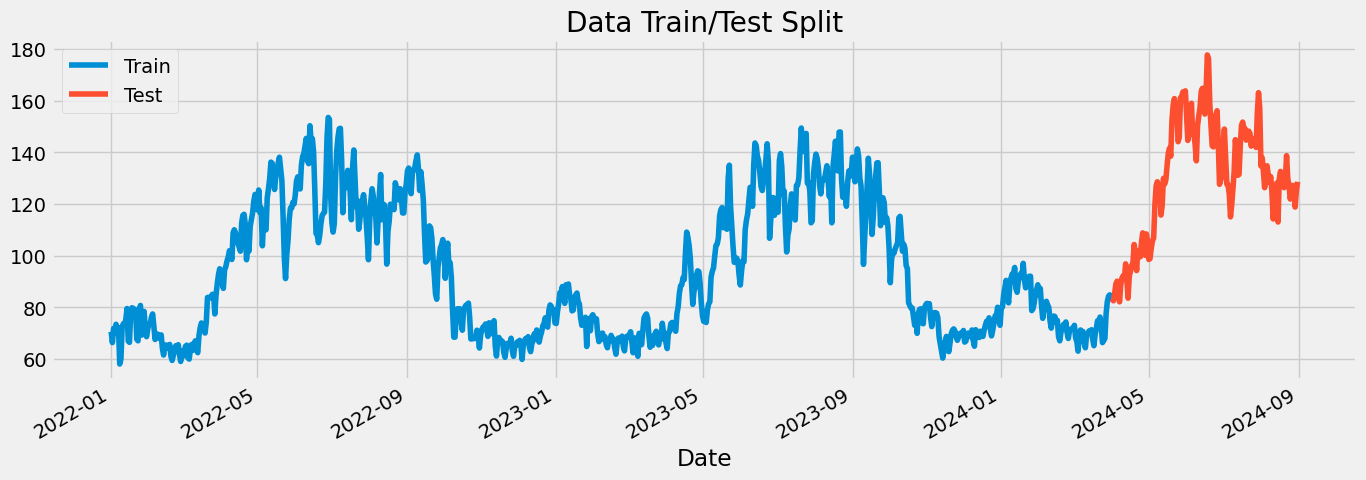

In [12]:
train = df.loc[df.index < '04-01-2024']
test = df.loc[df.index >= '04-01-2024']

fig, ax = plt.subplots(figsize=(15,5))
train['Energy Met (MU)'].plot(ax=ax, label='Train',title='Data Train/Test Split')
test['Energy Met (MU)'].plot(ax=ax, label='Test')
plt.legend()
plt.show()

# Visualize F/T Relationship

<Axes: xlabel='month', ylabel='Max Demand Met (MW)'>

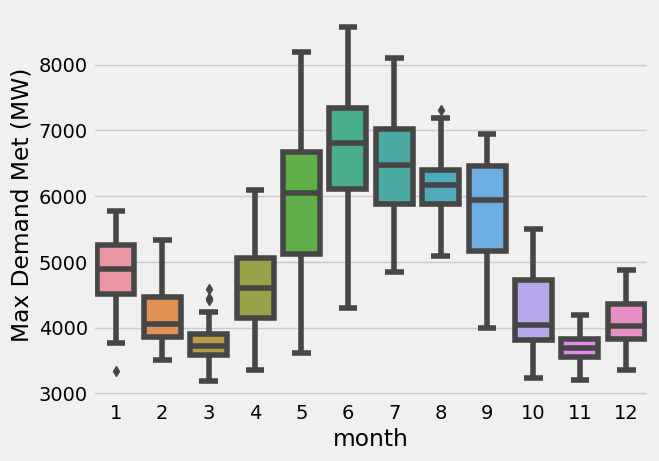

In [13]:
sns.boxplot(data=df, x='month', y='Max Demand Met (MW)')

<Axes: xlabel='month', ylabel='Energy Met (MU)'>

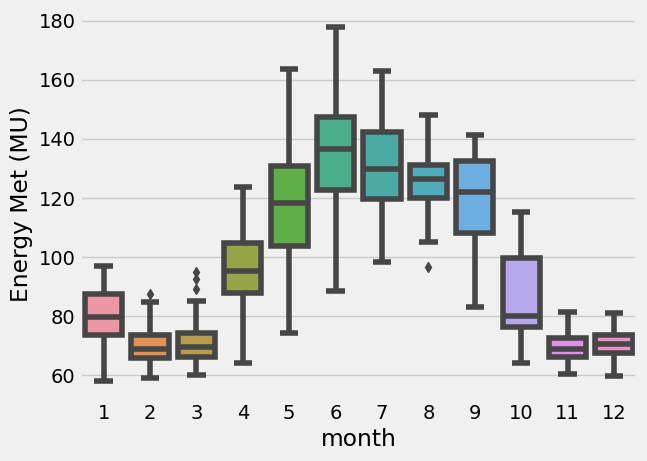

In [14]:
sns.boxplot(data=df,x='month',y = 'Energy Met (MU)')

# The Model & Factors Importance

[0]	validation_0-rmse:5169.35431	validation_1-rmse:7108.85452
[100]	validation_0-rmse:1946.58788	validation_1-rmse:2952.58882
[200]	validation_0-rmse:784.58811	validation_1-rmse:1357.50363
[300]	validation_0-rmse:400.35682	validation_1-rmse:804.32095
[400]	validation_0-rmse:292.72021	validation_1-rmse:620.10915
[500]	validation_0-rmse:263.10389	validation_1-rmse:545.57301
[600]	validation_0-rmse:249.33305	validation_1-rmse:502.25564
[700]	validation_0-rmse:239.49450	validation_1-rmse:481.94423
[800]	validation_0-rmse:230.19492	validation_1-rmse:466.11378
[900]	validation_0-rmse:221.99754	validation_1-rmse:454.12790
[999]	validation_0-rmse:214.90457	validation_1-rmse:443.09030
[0]	validation_0-rmse:100.74180	validation_1-rmse:144.67387
[100]	validation_0-rmse:37.85409	validation_1-rmse:59.96455
[200]	validation_0-rmse:15.05322	validation_1-rmse:27.04245
[300]	validation_0-rmse:7.30959	validation_1-rmse:15.08644
[400]	validation_0-rmse:5.02049	validation_1-rmse:10.52263
[500]	validation_

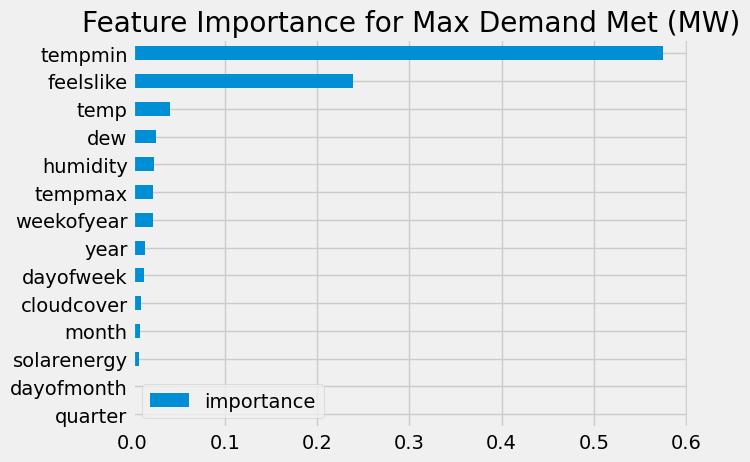

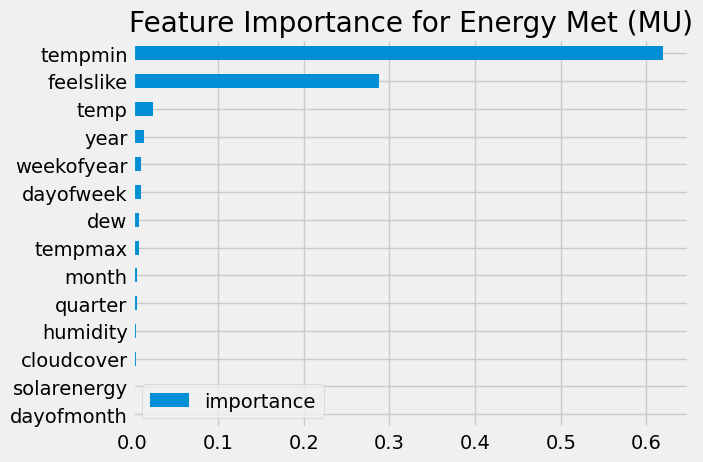

In [15]:
def plot_feature_importances(model, feature_names, title):
    fi = pd.DataFrame(data=model.feature_importances_,
                      index=feature_names,
                      columns=['importance'])
    fi.sort_values('importance').plot(kind='barh', title=title)
    plt.show()
    
    
tss = TimeSeriesSplit(n_splits=5, test_size=7, gap=0)
df = df.sort_index()

preds = {target: [] for target in ['Max Demand Met (MW)', 'Energy Met (MU)']}
scores = {target: [] for target in ['Max Demand Met (MW)', 'Energy Met (MU)']}

model_dict = {target: xgb.XGBRegressor(
    base_score=0.5, booster='gbtree',
    n_estimators=1000, early_stopping_rounds=50,
    objective='reg:squarederror', max_depth=3,
    learning_rate=0.01
) for target in ['Max Demand Met (MW)', 'Energy Met (MU)']}

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    train = create_features(train)
    test = create_features(test)
    
    FEATURES = ['dayofweek', 'tempmax', 'tempmin', 'temp', 'feelslike', 'cloudcover', 'dew', 'humidity', 'solarenergy', 'quarter', 'month', 'year', 'dayofmonth', 'weekofyear']
    
    for TARGET in ['Max Demand Met (MW)', 'Energy Met (MU)']:
        X_train = train[FEATURES]
        y_train = train[TARGET]

        X_test = test[FEATURES]
        y_test = test[TARGET]
        
        model = model_dict[TARGET]
        model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_test, y_test)],
                  verbose=100)
        
        y_pred = model.predict(X_test)
        preds[TARGET].append(y_pred)
        
        score = np.sqrt(mean_squared_error(y_test, y_pred))
        scores[TARGET].append(score)
        
for target in ['Max Demand Met (MW)', 'Energy Met (MU)']:
    print(f"Scores for {target}: {scores[target]}")
    print(f"Mean Score for {target}: {np.mean(scores[target])}")    
    
for TARGET in ['Max Demand Met (MW)', 'Energy Met (MU)']:
    model = model_dict[TARGET]
    plot_feature_importances(model, X_train.columns, f'Feature Importance for {TARGET}')

In [16]:
# Make predictions 
"""
test['prediction_maxDemand'] = reg_maxDemand.predict(X_test)
test['prediction_energyMet'] = reg_energyMet.predict(X_test)

df = df.merge(test[['prediction_maxDemand', 'prediction_energyMet']], 
              how='left', left_index=True, right_index=True)

# for Max Demand Met (MW)
ax = df[['Max Demand Met (MW)']].plot(figsize=(15, 5))
df['prediction_maxDemand'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Max Demand Met (MW): Raw Data and Prediction')
plt.show()

# for Energy Met (MU)
ax = df[['Energy Met (MU)']].plot(figsize=(15, 5))
df['prediction_energyMet'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Energy Met (MU): Raw Data and Prediction')
plt.show()
"""

"\ntest['prediction_maxDemand'] = reg_maxDemand.predict(X_test)\ntest['prediction_energyMet'] = reg_energyMet.predict(X_test)\n\ndf = df.merge(test[['prediction_maxDemand', 'prediction_energyMet']], \n              how='left', left_index=True, right_index=True)\n\n# for Max Demand Met (MW)\nax = df[['Max Demand Met (MW)']].plot(figsize=(15, 5))\ndf['prediction_maxDemand'].plot(ax=ax, style='.')\nplt.legend(['Truth Data', 'Predictions'])\nax.set_title('Max Demand Met (MW): Raw Data and Prediction')\nplt.show()\n\n# for Energy Met (MU)\nax = df[['Energy Met (MU)']].plot(figsize=(15, 5))\ndf['prediction_energyMet'].plot(ax=ax, style='.')\nplt.legend(['Truth Data', 'Predictions'])\nax.set_title('Energy Met (MU): Raw Data and Prediction')\nplt.show()\n"